# **1132_MIS581社群媒體分析_期末專案_第一組**
- 指導教授：黃三益
- 　　組員：郭展州N124020012、傅才容N124320030、莊筑雅N124320004、李明容N124320016


# **專案名稱：多層次特徵融合之假新聞偵測與主題分析系統**
## **Youtube**
https://youtu.be/PeFoQeL7atA
## **專案目標**
1. 精準判斷新聞或推文之真偽
2. 剖析假新聞常見主題與關鍵字
3. 結合多模型協作(傳統 ML × BERT/SBERT × LLM)，驗證不同特徵組合與分類器效果，建立可擴充的偵測流程
## **專案流程**
1. 資料蒐集與前處理
2. 各項特徵提取：NER特徵、情緒特徵、綜合特徵工程及分類模型評估
3. 主題模型BERTopic
4. LLM 多模型裁決
5. 最終整合評估
## **資料來源**
1. fake-and-real-news-dataset (ISOT Fake News detection dataset) https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
2. Twitter Dataset (Referenced from CIC Truth Seeker Dataset 2023) https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023/data?select=Truth_Seeker_Model_Dataset.csv

# **專案執行**

## 一、套件安裝與引入

In [1]:
# 🔧 安裝核心資料處理與模型套件
!pip install pandas numpy scikit-learn matplotlib seaborn tqdm nltk vaderSentiment empath tabulate
# 🔎 安裝 BERT 相關（transformers, pipeline）
!pip install transformers
# 🤖 安裝命名實體辨識用預訓練模型
!pip install torch
# 🧠 安裝情緒分析微調模型
!pip install sentence-transformers
# 📊 安裝主題建模：BERTopic + HDBSCAN（支援 clustering）
!pip install bertopic hdbscan
# 🗂 字體設定用（如你加載了自訂字體）
!pip install fonttools
!pip install --upgrade nltk

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# GPU 加速

import torch

# GPU 加速
print("=== PyTorch GPU 加速環境檢查 ===")
print(f"PyTorch 版本: {torch.__version__}")
print(f"PyTorch 編譯的 CUDA 版本: {torch.version.cuda}")
print(f"是否支援 CUDA: {torch.cuda.is_available()}")

try:
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        current_gpu = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(current_gpu)

        print(f"偵測到 {gpu_count} 個 GPU")
        print(f"當前使用的 GPU：{device_name}")
        device = torch.device("cuda")
    else:
        raise RuntimeError("CUDA 不可用，將使用 CPU")
except Exception as e:
    print(f"無法使用 GPU：{e}")
    device = torch.device("cpu")

print(f"pytorch可用的GPU為：{device}")


=== PyTorch GPU 加速環境檢查 ===
PyTorch 版本: 2.5.1+cu121
PyTorch 編譯的 CUDA 版本: 12.1
是否支援 CUDA: True
偵測到 1 個 GPU
當前使用的 GPU：NVIDIA GeForce RTX 4050 Laptop GPU
pytorch可用的GPU為：cuda


In [4]:
# === NLP / 資料處理基礎 ===
import os, re, ssl, json, concurrent.futures, warnings, itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

# NLTK ───────────────────────────────────────────────────────────
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.data.path.extend([
    '/usr/nltk_data', '/usr/local/nltk_data', '/usr/share/nltk_data',
    '/usr/local/share/nltk_data', '/root/nltk_data'
])

# === Scikit-learn 基礎工具 ===
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate)
from sklearn.feature_extraction.text import (
    TfidfVectorizer, CountVectorizer)
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, f1_score,
    accuracy_score, precision_score, recall_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 傳統分類器
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# === 進階 NLP / 向量化 ===
from sentence_transformers import SentenceTransformer          # SBERT
from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification)

# === 主題模型 / 聚類 ===
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# === 視覺化 ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import fontManager
fontManager.addfont('./public/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = 14

# === VADER & Empath (情緒 / 詞典) ===
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
try:
    from empath import Empath
    empath_available = True
    empath_lexicon = Empath()
except ModuleNotFoundError:
    empath_available = False
    warnings.warn("Empath 尚未安裝，將略過相關特徵。")

# === 其他輔助 ===
from tabulate import tabulate
warnings.filterwarnings('ignore')  # 避免雜訊訊息

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 匯入fake-and-real-news-dataset真假新聞資料集

In [5]:
# 載入fake-and-real-news-dataset資料集
fake_df = pd.read_csv('./raw_data/fake.csv')            
true_df = pd.read_csv('./raw_data/true.csv')            

# 合併 title 和 text 成新的 text 欄位
fake_df['text'] = fake_df['title'].astype(str) + " " + fake_df['text'].astype(str)
true_df['text'] = true_df['title'].astype(str) + " " + true_df['text'].astype(str)

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

# 取前 1000 筆
# dataNum = 1000
# news_data = pd.concat([fake_df.iloc[:dataNum], true_df.iloc[:dataNum]], ignore_index=True)
# news_data = fake_df

# 取一半(資料量過大)
fake_half = fake_df.sample(frac=0.25, random_state=42)
true_half = true_df.sample(frac=0.25, random_state=42)
news_data = pd.concat([fake_half, true_half], ignore_index=True)

# 移除空值並只保留 text 和 label 欄位
news_data = news_data[news_data['text'].notna()].reset_index(drop=True)
news_data = news_data[['text', 'label']]

# 檢查各類別數量
print(news_data['label'].value_counts())
print(news_data.head(1))

label
1    5870
0    5354
Name: count, dtype: int64
                                                text  label
0  ABOUT HILLARY’S COUGH: We Discovered The Secre...      1


### 匯入Twitter Dataset推特真假推文資料集

In [6]:
# 推特資料處理(為了嘗試解決 加入TF-IDF過擬合&embed過強 可能是因為文本特徵太明顯的問題)
tweet_df = pd.read_csv(
    './raw_data/Truth_Seeker_Model_Dataset_unindex.csv', encoding='ISO-8859-1')
tweet_data = tweet_df[['BinaryNumTarget',
                       'tweet', '5_label_majority_answer']].copy()

# 清理
tweet_data = tweet_data.dropna()
tweet_data = tweet_data[~tweet_data['tweet'].str.contains('#REF!', na=False)]
valid_labels = ['Agree', 'Mostly Agree']
tweet_data = tweet_data[tweet_data['5_label_majority_answer'].isin(
    valid_labels)]

# 移除 5_label_majority_answer 欄位，並重新命名欄位
tweet_data = tweet_data.rename(
    columns={'BinaryNumTarget': 'label', 'tweet': 'text'})
tweet_data = tweet_data[['text', 'label']]

tweet_data_num = 50  # 取n筆
# 取一半
min_half = int(min(tweet_data['label'].value_counts()) / 4)
# tweet_data = tweet_data.groupby('label').apply(
#     lambda x: x.sample(n=min(len(x), min_half), random_state=42)
# ).reset_index(drop=True)
tweet_data = tweet_data.groupby('label').apply(
    lambda x: x.sample(n=min_half, random_state=42)
).reset_index(drop=True)

print(tweet_data['label'].value_counts())
print(tweet_data.head(10))

label
0    13112
1    13112
Name: count, dtype: int64
                                                text  label
0  @judyannaggie @RichardGrenell That's why the b...      0
1  @drmeowza I  so sorry that you are I'll. I wis...      0
2  @charlie_savage You do realize he said AntiFa ...      0
3  @AshleeFulcher1 @JennieNguyenLuv So you agree ...      0
4    Bruno Mars is Michael Jackson secret son.......      0
5  The CDC admitted that it is mixing antibody an...      0
6  @mutxtiger @MacFarlaneNews @JWilson420yes He s...      0
7  @matanevenoff @SpeakerPelosi Why this is insan...      0
8  KAMLA HARRIS praises the Marxists BlackLivesMa...      0
9  @blackbartohio In 38 days Pelosi and Schiff \n...      0


In [7]:
# 合併兩份不同來源資料集
data = pd.concat([news_data, tweet_data], ignore_index=True)

**需要做文本預處理嗎?**

目的:
- 建立分類器來預測真假新聞 -> (TF-IDF + 分類模型需要乾淨的資料，有幫助)
- 分析NER 結果與語意分佈 -> (會破壞語意)
- 建立主題模型來探索語意主題（BERTopic -> (會破壞語意)

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punct_pattern = re.compile(r"[^a-z ]")

def preprocess(text):
    text = text.lower()
    text = punct_pattern.sub(" ", text)
    # 用 preserve_line=True 避開 punkt_tab
    tokens = word_tokenize(text, preserve_line=True)
    tokens = [
        lemmatizer.lemmatize(w)
        for w in tokens
        if w not in stop_words and len(w) > 1
    ]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))

## 二、各項特徵處理與分類器評估表現
### NER特徵處理

In [9]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# 載入模型與 tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

# 建立 NER 結果列表
ner_rows = []

# 分切字串
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 針對每篇文章跑 NER（可用 tqdm 顯示進度條）
for idx, text in tqdm(data['text'].astype(str).items()):
    try:
        chunks = split_text(text)
        all_ents = []
        for chunk in chunks:
            all_ents.extend(ner_pipeline(chunk))  # 對每段跑 NER
        for ent in all_ents:
            ner_rows.append({
                "index": idx,
                "entity": ent['entity_group'],  # e.g., PER, LOC
                "word": ent['word'],
                "score": ent['score']
            })
    except Exception as e:
        print(f"Error at idx {idx}: {e}")

# 建立 DataFrame
ner_df = pd.DataFrame(ner_rows)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
4it [00:00, 19.07it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
37448it [19:05, 32.70it/s]


In [10]:
ner_df.head(10)

,index,entity,word,score
0,1,PER,O,0.866889
1,1,ORG,First,0.594340
2,1,ORG,Senate,0.998374
3,1,MISC,S. Con. Res,0.798432
4,1,MISC,Obamacare,0.976125
5,1,MISC,Budget,0.638583
6,1,PER,Mike Enzi,0.976281
7,1,MISC,A,0.999032
8,1,MISC,##able Care Act,0.997360
9,1,PER,Donald Trump,0.999415


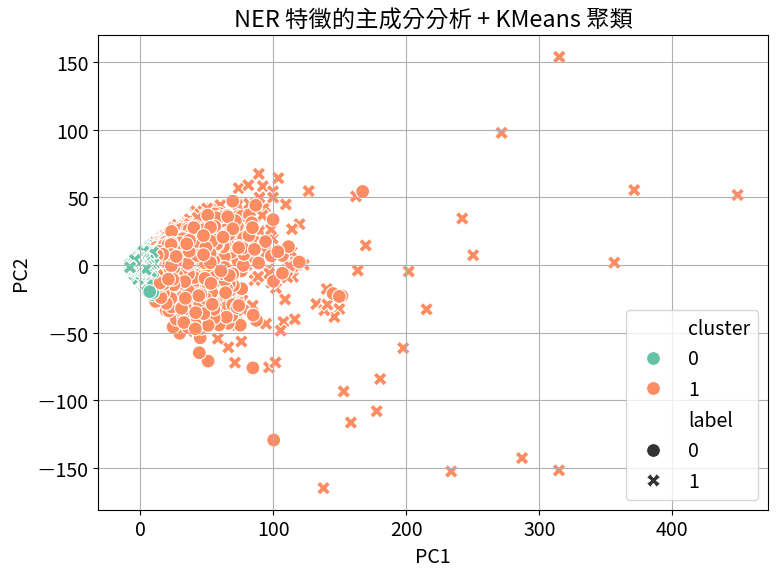

In [11]:
# 整合 label
merged_df = ner_df.merge(data[['label']], left_on='index', right_index=True)

# 聚合所有 entity 類型的出現次數
entity_counts_all = (
    merged_df.groupby(['index', 'entity'])
    .size()
    .unstack(fill_value=0)  # 得到每篇文章各類實體數
    .reset_index()
)

# 合併 label
entity_counts_all = entity_counts_all.merge(data[['label']], left_on='index', right_index=True)

# 建模欄位選擇：所有實體類別欄位（排除 index, label）
feature_cols = [col for col in entity_counts_all.columns if col not in ['index', 'label']]
kmeans_fit_pred_data = entity_counts_all[feature_cols]

# 做 KMeans 聚類
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2, random_state=42)
entity_counts_all['cluster'] = kmeans.fit_predict(kmeans_fit_pred_data)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_fit_pred_data)
entity_counts_all['PC1'] = X_pca[:, 0]
entity_counts_all['PC2'] = X_pca[:, 1]
# 視覺化聚類結果
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=entity_counts_all,
    x='PC1', y='PC2', hue='cluster', style='label',
    palette='Set2', s=100
)

plt.title('NER 特徵的主成分分析 + KMeans 聚類')
plt.grid(True)
plt.tight_layout()
plt.show()

1. 使用NER特徵進行KMeans聚類，無監督學習自動分成兩群，上圖為模型前的探索性資料分析(EDA)結果，觀察結果:KMeans聚類有部分成功聚出假新聞群，綠色cluster1幾乎都是叉叉為假新聞群，橘色cluster0包含較多真新聞與部分假新聞。
2. 結論：分群重疊明顯，整體分群效果不算非常好，但初步判斷NER有區別能力，需結合更多特徵進行多模態聚類模型評估!

### 多模態特徵+分類器評估

#### A. 使用「命名實體識別(NER)」來辨識真假新聞
使用NER當作特徵，提取出的`人名`、`組織`、`地名數量`作為詞彙特徵，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`評估結果來分類真假新聞，預測這篇新聞是真/假。

In [12]:
from sklearn import svm

# ── Part 1：NER特徵模型比較 ───────────────────────────
# === 建立特徵（NER 例子） ===
entity_counts = ner_df.groupby(['index', 'entity']).size().unstack(fill_value=0)
data_with_ner = data.copy()
data_with_ner = data_with_ner.join(entity_counts, how='left').fillna(0)

X = data_with_ner[['PER', 'ORG', 'LOC']]
y = data_with_ner['label']

# === 分類器列表 ===
# classifiers = {
#     "LogReg": LogisticRegression(max_iter=1000),
#     "DecisionTree": DecisionTreeClassifier(),
#     "SVM": svm.SVC(probability=True),
#     "RandomForest": RandomForestClassifier(random_state=42)
# }
classifiers = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "SVM": svm.SVC(probability=True),
    "RandomForest": RandomForestClassifier(random_state=42)
}

# === K-fold 設定 ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 儲存平均 f1-score 結果
results = []

# === 執行交叉驗證並印出每個模型報告 ===
for name, model in classifiers.items():
    print(f"\n=== {name} 分類結果（5-fold） ===")
    y_true_all, y_pred_all = [], []
    fold_f1_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        fold_f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    avg_f1 = np.mean(fold_f1_scores)
    print(classification_report(
        y_true_all, y_pred_all,
        target_names=["真新聞", "假新聞"],
        digits=2
    ))

    results.append({
        "classifier": name,
        "f1_weighted": avg_f1
    })

# === 比較結果表格 ===
result_df = pd.DataFrame(results).sort_values(by="f1_weighted", ascending=False).reset_index(drop=True)
print("🏁 各模型比較：")
print(tabulate(result_df, headers="keys", tablefmt="fancy_grid"))

# === 找出最佳模型 ===
best = result_df.iloc[0]
print(f"\n🏆 最佳分類器為：{best['classifier']}，weighted F1 = {best['f1_weighted']:.4f}")



=== LogReg 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.54      0.33      0.41     18466
         假新聞       0.53      0.72      0.61     18982

    accuracy                           0.53     37448
   macro avg       0.53      0.53      0.51     37448
weighted avg       0.53      0.53      0.51     37448


=== DecisionTree 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.59      0.49      0.54     18466
         假新聞       0.57      0.67      0.62     18982

    accuracy                           0.58     37448
   macro avg       0.58      0.58      0.58     37448
weighted avg       0.58      0.58      0.58     37448


=== SVM 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.61      0.53      0.57     18466
         假新聞       0.59      0.67      0.63     18982

    accuracy                           0.60     37448
   macro avg       0.60      0.60     

+ NER提取特徵預測結果尚可，NER特徵對真假新聞辨識有一定程度作用，`最佳分類器：SVM`，`Weighted F1 = 0.5968`。
+ 結論：特徵太少，只有三維「人名/地名/組織」，資訊量太低。很多新聞或推文不一定包含這三類實體，變成無效資料。。

#### B. 使用「情緒分析」來辨識真假新聞

利用`多個情緒特徵模型進行`，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較，評估最佳結果來分類真假新聞，預測這篇新聞是真/假。
+ **情緒模型介紹：**
1. distilbert：一款基於SST-2微調的輕量級BERT模型，常用於英文產品評論或客服對話中的情緒正負分類任務。
2. roberta-twitter：專為Twitter資料訓練的RoBERTa模型，廣泛應用於社群貼文的輿情分析與社會事件情緒偵測。
3. bertweet：以海量推文語料訓練的BERT模型，特別適用於社群媒體上的即時情緒追蹤與用戶反應分析。
4. nlptown：一個支援多語言、可輸出1～5星等級的情緒強度模型，常用於多語評論評等、顧客滿意度分析等任務。

In [13]:
from tqdm import tqdm

# ── Part 2：情緒特徵模型比較 ───────────────────────────
sentiment_models = {
    "distilbert"      : "distilbert-base-uncased-finetuned-sst-2-english",
    "roberta-twitter" : "cardiffnlp/twitter-roberta-base-sentiment",
    "bertweet"        : "finiteautomata/bertweet-base-sentiment-analysis",
    "nlptown"         : "nlptown/bert-base-multilingual-uncased-sentiment"
}
# sentiment_models = {
#     "bertweet"        : "finiteautomata/bertweet-base-sentiment-analysis"
# }

classifiers = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "LinearSVC"    : LinearSVC(),
    "RandomForest" : RandomForestClassifier(random_state=42)
}

# classifiers = {
#     "RandomForest" : RandomForestClassifier(random_state=42)
# }

# 使用 tokenizer 分段，每段不超過 max_tokens（不含 special tokens）
def tokenize_chunks(text, tokenizer, max_tokens=512):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    if len(tokens) <= max_tokens:
        return [text]
    chunked_tokens = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.decode(chunk) for chunk in chunked_tokens]

def split_chunks(txt, size=512):
    return [txt[i:i+size] for i in range(0, len(txt), size)]

def senti_score(txt, pipe):
    try:
        res = pipe(split_chunks(txt))
        pos = [r['score'] for r in res if 'POS' in r['label'].upper()]
        neg = [r['score'] for r in res if 'NEG' in r['label'].upper()]
        return (sum(pos)/len(pos)) if pos and sum(pos) > sum(neg) \
               else -(sum(neg)/len(neg)) if neg else 0.0
    except Exception:
        return 0.0
    
# 批次處理 + 情緒得分
def senti_score_batch(texts, model_name, batch_size=16, max_tokens=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    pipe = pipeline("sentiment-analysis", model=model_name, device=0 if torch.cuda.is_available() else -1)
    
    all_scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Token-based Sentiment Inference"):
        batch = texts[i:i + batch_size]
        batch_scores = []

        for text in batch:
            try:
                chunks = tokenize_chunks(text, tokenizer, max_tokens=max_tokens)
                results = [pipe(chunk)[0] for chunk in chunks]  # 每段丟進 sentiment pipeline

                pos = [r['score'] for r in results if 'POS' in r['label'].upper()]
                neg = [r['score'] for r in results if 'NEG' in r['label'].upper()]
                score = (sum(pos) / len(pos)) if pos and sum(pos) > sum(neg) \
                        else -(sum(neg) / len(neg)) if neg else 0.0
            except:
                score = 0.0
            batch_scores.append(score)

        all_scores.extend(batch_scores)
    return all_scores

def compute_sentiment_scores(texts, model_name, batch_size=32):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

    scores = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            # 依模型標籤格式來處理：
            if probs.shape[1] == 3:  # eg: [NEG, NEU, POS]
                score = (probs[:, 2] - probs[:, 0]).cpu().numpy()
            elif probs.shape[1] == 2:  # eg: [NEG, POS]
                score = (probs[:, 1] - probs[:, 0]).cpu().numpy()
            else:
                score = probs[:, 1].cpu().numpy()  # fallback
            scores.extend(score)
    return scores

all_results, model_mean = [], []

for m_key, m_name in sentiment_models.items():
    print(f"\n🔍 Sentiment Model: {m_key}")
    data_tmp = data.copy()
    # 修正方法
    texts = data_tmp['text'].astype(str).tolist()
    data_tmp['sentiment_score'] = senti_score_batch(
        texts, model_name=m_name, batch_size=16  # 可依照 GPU 調整
    )

    X_senti = data_tmp[['sentiment_score']]
    y       = data_tmp['label']

    f1_collect = []
    for clf_key, clf in classifiers.items():
        X_tr, X_te, y_tr, y_te = train_test_split(X_senti, y, test_size=0.2, random_state=42)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        f1_val = f1_score(y_te, y_pred, average='weighted')
        f1_collect.append(f1_val)
        all_results.append({"model": m_key, "classifier": clf_key, "f1": f1_val})

    model_mean.append({"model": m_key, "mean_f1": np.mean(f1_collect)})

# ➜ 找平均 F1 最高的情緒模型
model_df = pd.DataFrame(model_mean).sort_values('mean_f1', ascending=False)
best_senti = model_df.iloc[0]['model']
print("\n📊  情緒模型平均 F1：")
print(tabulate(model_df, headers="keys", tablefmt="fancy_grid"))
print(f"\n🏆 最佳情緒模型：{best_senti}")



🔍 Sentiment Model: distilbert


Device set to use cuda:0
Token-based Sentiment Inference:   0%|          | 0/2341 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token-based Sentiment Inference: 100%|██████████| 2341/2341 [03:32<00:00, 11.00it/s]



🔍 Sentiment Model: roberta-twitter



All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0
Token-based Sentiment Inference: 100%|██████████| 2341/2341 [2:08:56<00:00,  3.30s/it]  



🔍 Sentiment Model: bertweet


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0
Token-based Sentiment Inference:   0%|          | 0/2341 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (279 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (281 > 128). Running this sequence through the model will result in indexing errors
Token-based Sentiment Inference: 100%|██████████| 2341/2341 [1:30:17<00:00,  2.31s/it]



🔍 Sentiment Model: nlptown


Device set to use cuda:0
Token-based Sentiment Inference:   0%|          | 0/2341 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token-based Sentiment Inference: 100%|██████████| 2341/2341 [05:57<00:00,  6.55it/s]



📊  情緒模型平均 F1：
╒════╤═════════════════╤═══════════╕
│    │ model           │   mean_f1 │
╞════╪═════════════════╪═══════════╡
│  0 │ distilbert      │  0.510371 │
├────┼─────────────────┼───────────┤
│  2 │ bertweet        │  0.506332 │
├────┼─────────────────┼───────────┤
│  1 │ roberta-twitter │  0.34332  │
├────┼─────────────────┼───────────┤
│  3 │ nlptown         │  0.34332  │
╘════╧═════════════════╧═══════════╛

🏆 最佳情緒模型：distilbert


+ 結論： 情緒預測真假新聞表現不好，整體分類效果偏弱，`最佳情緒模型：distilbert`，`最佳分類器：RandomForest`，`Weighted F1 =0.74 `。

#### C. 使用「NER+情緒」來辨識真假新聞
延續步驟B選出最佳情緒模型`distilbert`後，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較。

Device set to use cuda:0
Token-based Sentiment Inference:   0%|          | 0/2341 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token-based Sentiment Inference: 100%|██████████| 2341/2341 [03:27<00:00, 11.31it/s]



=== LogReg 整體報告 ===
              precision    recall  f1-score   support

         真新聞       0.53      0.58      0.55     18466
         假新聞       0.55      0.51      0.53     18982

    accuracy                           0.54     37448
   macro avg       0.54      0.54      0.54     37448
weighted avg       0.54      0.54      0.54     37448


=== DecisionTree 整體報告 ===
              precision    recall  f1-score   support

         真新聞       0.56      0.55      0.55     18466
         假新聞       0.57      0.57      0.57     18982

    accuracy                           0.56     37448
   macro avg       0.56      0.56      0.56     37448
weighted avg       0.56      0.56      0.56     37448


=== SVM 整體報告 ===
              precision    recall  f1-score   support

         真新聞       0.60      0.57      0.59     18466
         假新聞       0.60      0.63      0.62     18982

    accuracy                           0.60     37448
   macro avg       0.60      0.60      0.60     37448
weighted

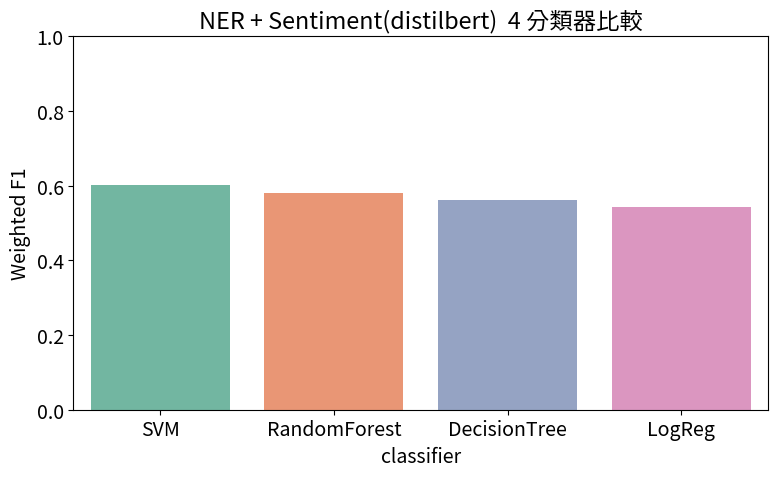

In [14]:
# ── Part 3：NER + Best Sentiment 特徵訓練 ──────────────
# 1️⃣ 用最佳情緒模型重新計算 sentiment_score
# best_pipe = pipeline("sentiment-analysis", model=sentiment_models[best_senti], truncation=True, device=0 if device.type == "cuda" else -1)
# tqdm.pandas()
# data['sentiment_score'] = data['text'].astype(str).progress_apply(lambda t: senti_score(t, best_pipe))
texts = data['text'].astype(str).tolist()
data['sentiment_score'] = senti_score_batch(
    texts, model_name=sentiment_models[best_senti], batch_size=16  # GPU + batch
)

# 2️⃣ 合併 NER (PER/ORG/LOC) + sentiment_score
feature_df = data_with_ner[['PER', 'ORG', 'LOC']].join(data['sentiment_score'])
X_full = feature_df
y_full = data['label']

# 3️⃣ 四個分類器
final_clfs = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "SVM"          : svm.SVC(probability=True),
    "RandomForest" : RandomForestClassifier(random_state=42)
}
# final_clfs = {
#     "RandomForest" : RandomForestClassifier(random_state=42)
# }

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_res = []

for clf_key, base_clf in final_clfs.items():
    y_all_t, y_all_p, f1_list = [], [], []

    for tr_idx, te_idx in kf.split(X_full, y_full):
        X_tr, X_te = X_full.iloc[tr_idx], X_full.iloc[te_idx]
        y_tr, y_te = y_full.iloc[tr_idx], y_full.iloc[te_idx]

        clf = clone(base_clf)
        clf.fit(X_tr, y_tr)
        y_pr = clf.predict(X_te)

        y_all_t.extend(y_te); y_all_p.extend(y_pr)
        f1_list.append(f1_score(y_te, y_pr, average='weighted'))

    print(f"\n=== {clf_key} 整體報告 ===")
    print(classification_report(y_all_t, y_all_p, target_names=["真新聞","假新聞"], digits=2))

    final_res.append({"classifier": clf_key, "f1_weighted": np.mean(f1_list)})

# 4️⃣ 比較表 & 最佳分類器
final_df = pd.DataFrame(final_res).sort_values('f1_weighted', ascending=False).reset_index(drop=True)
print("\n📊  最終 4 分類器比較：")
print(tabulate(final_df, headers="keys", tablefmt="fancy_grid"))

best_cls = final_df.iloc[0]
print(f"\n🏆 最終最佳組合：情緒模型={best_senti} + 分類器={best_cls['classifier']}，weighted F1={best_cls['f1_weighted']:.4f}")

# 5️⃣ (可選) 視覺化
plt.figure(figsize=(8,5))
sns.barplot(x='classifier', y='f1_weighted', data=final_df, palette='Set2')
plt.title(f'NER + Sentiment({best_senti})  4 分類器比較')
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


+ 結論：可在進行優化，`最佳分類器：SVM`，`Weighted F1 =0.6014 `。

#### D. 使用「NER+情緒+TFIDF」來辨識真假新聞
延續步驟C.加入`TFIDF`，，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較。

Device set to use cuda:0
100%|██████████| 37448/37448 [07:30<00:00, 83.05it/s] 



=== LogReg 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.82      0.77      0.79     18466
         假新聞       0.79      0.84      0.81     18982

    accuracy                           0.80     37448
   macro avg       0.80      0.80      0.80     37448
weighted avg       0.80      0.80      0.80     37448


=== DecisionTree 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.80      0.80      0.80     18466
         假新聞       0.81      0.81      0.81     18982

    accuracy                           0.81     37448
   macro avg       0.81      0.81      0.81     37448
weighted avg       0.81      0.81      0.81     37448


=== SVM 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.81      0.60      0.69     18466
         假新聞       0.69      0.87      0.77     18982

    accuracy                           0.73     37448
   macro avg       0.75      0.73     

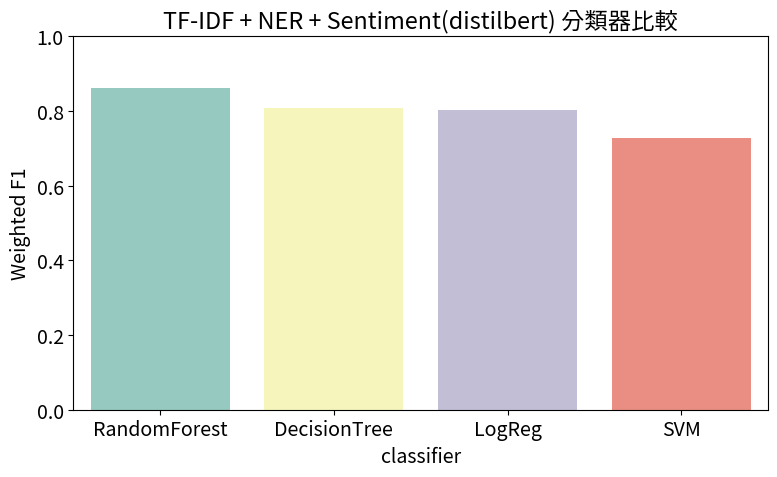

In [15]:
# ── Part 4：TF-IDF + NER + Best Sentiment 模型 ──────────────────────
# ✅ 使用 Part 2 最佳情緒模型重新生成 sentiment_score
senti_model_name = sentiment_models[best_senti]
sentiment_pipe = pipeline("sentiment-analysis", model=senti_model_name, truncation=True, device=0 if device.type == "cuda" else -1)
tqdm.pandas()
data['sentiment_score'] = data['text'].astype(str).progress_apply(lambda t: senti_score(t, sentiment_pipe))

# 1️⃣ 建立 TF-IDF 特徵
tfidf_vec = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
tfidf_mat = tfidf_vec.fit_transform(data['clean_text'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_mat.toarray(),
                        columns=tfidf_vec.get_feature_names_out(),
                        index=data.index)

# 2️⃣ 取得 NER 特徵 + 最新 sentiment 分數
ner_df     = data_with_ner[['PER', 'ORG', 'LOC']].copy()
senti_df   = data[['sentiment_score']]
X_features = pd.concat([ner_df, senti_df, tfidf_df], axis=1)
y_target   = data['label']

# 3️⃣ 定義分類器
classifiers = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "SVM"          : svm.SVC(probability=True),
    "RandomForest" : RandomForestClassifier(random_state=42)
}
# classifiers = {
#     "RandomForest" : RandomForestClassifier(random_state=42)
# }

# 4️⃣ Cross-Validation 訓練
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for clf_name, clf_model in classifiers.items():
    print(f"\n=== {clf_name} 分類結果（5-fold） ===")
    y_all_true, y_all_pred, f1s = [], [], []

    for train_idx, test_idx in kf.split(X_features, y_target):
        X_train, X_test = X_features.iloc[train_idx], X_features.iloc[test_idx]
        y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]

        clf = clone(clf_model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_all_true.extend(y_test)
        y_all_pred.extend(y_pred)
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    print(classification_report(y_all_true, y_all_pred,
                                target_names=["真新聞", "假新聞"], digits=2))

    results.append({
        "classifier": clf_name,
        "f1_weighted": np.mean(f1s)
    })

# 5️⃣ 輸出總結
result_df = pd.DataFrame(results).sort_values(by='f1_weighted', ascending=False).reset_index(drop=True)

print("\n📊 TF-IDF + NER + Sentiment 分類器比較：")
print(tabulate(result_df, headers="keys", tablefmt="fancy_grid"))

best = result_df.iloc[0]
print(f"\n🏆 最佳分類器為：{best['classifier']}，weighted F1 = {best['f1_weighted']:.4f}")

# ➕ 可選視覺化
plt.figure(figsize=(8,5))
sns.barplot(x='classifier', y='f1_weighted', data=result_df, palette='Set3')
plt.title(f"TF-IDF + NER + Sentiment({best_senti}) 分類器比較")
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 依 label 分群
true_texts = data[data['label'] == 0]['clean_text'].fillna('')
fake_texts = data[data['label'] == 1]['clean_text'].fillna('')

# 建立 TF-IDF 向量器（可使用相同設定以便比較）
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))

# 擬合於真新聞
true_tfidf_matrix = tfidf.fit_transform(true_texts)
true_feature_names = tfidf.get_feature_names_out()
true_scores = true_tfidf_matrix.mean(axis=0).A1
true_top30 = sorted(zip(true_feature_names, true_scores), key=lambda x: x[1], reverse=True)[:30]

# 擬合於假新聞（需重新建一個 vectorizer 才不會共用字典）
tfidf_fake = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
fake_tfidf_matrix = tfidf_fake.fit_transform(fake_texts)
fake_feature_names = tfidf_fake.get_feature_names_out()
fake_scores = fake_tfidf_matrix.mean(axis=0).A1
fake_top30 = sorted(zip(fake_feature_names, fake_scores), key=lambda x: x[1], reverse=True)[:30]

# 將兩個 DataFrame 加上 index 並 reset
true_df = pd.DataFrame(true_top30, columns=["真新聞詞", "真_TF-IDF"]).reset_index(drop=True)
fake_df = pd.DataFrame(fake_top30, columns=["假新聞詞", "假_TF-IDF"]).reset_index(drop=True)

# 合併為一個表格（左右比對）
compare_df = pd.concat([true_df, fake_df], axis=1)

# 顯示結果
from IPython.display import display
print("📊 真新聞 vs 假新聞 前 30 常見關鍵詞（TF-IDF 分數）")
display(compare_df)

📊 真新聞 vs 假新聞 前 30 常見關鍵詞（TF-IDF 分數）


,真新聞詞,真_TF-IDF,假新聞詞,假_TF-IDF
0,trump,0.038157,trump,0.048493
1,said,0.035878,american,0.021921
2,biden,0.028797,people,0.021222
3,vaccine,0.025206,year,0.020467
4,people,0.020545,obama,0.019531
5,state,0.020239,state,0.019110
6,covid,0.019191,tax,0.016105
7,would,0.017973,president,0.016001
8,tax,0.017694,said,0.015923
9,president,0.017043,one,0.015902


+ 利用TFIDF找出真假新聞常見關鍵字。
+ 結論：加入TFIDF後，分類器效果提升，`最佳分類器：RandomForest`，`Weighted F1 = 0.8604`。

#### E. 使用「NER+情緒+TFIDF」加入其他VADER&文字Style來辨識真假新聞
延續步驟D.加入`VADER(+Empath)與文字表達Style特徵`，，加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`比較。

🔍 自動偵測到 30 個假新聞高相關詞（前 30）：
['america', 'american', 'black', 'clinton', 'com', 'fact', 'featured', 'featured image', 'fox', 'getty', 'getty image', 'gop', 'hillary', 'http', 'image', 'know', 'like', 'obama', 'pic', 'pic twitter', 'president obama', 'story', 'thing', 'trump', 'twitter', 'twitter com', 'video', 'watch', 'wire', 'woman']


100%|██████████| 37448/37448 [01:16<00:00, 490.28it/s] 



🧠 VADER 情緒推動特徵（前幾筆）：
   vader_neg  vader_neu  vader_pos  vader_compound
0      0.000      1.000      0.000          0.0000
1      0.023      0.856      0.121          0.9658
2      0.000      0.848      0.152          0.8757
3      0.096      0.815      0.089         -0.4557
4      0.048      0.912      0.040         -0.5698


100%|██████████| 37448/37448 [04:19<00:00, 144.17it/s]



🎯 NRC-Empath 情緒向量（前幾筆）：
   empath_positive_emotion  empath_negative_emotion  empath_anger  \
0                 0.000000                 0.000000       0.00000   
1                 0.000000                 0.009174       0.00000   
2                 0.000000                 0.000000       0.00000   
3                 0.002710                 0.002710       0.00271   
4                 0.001859                 0.000000       0.00000   

   empath_sadness  empath_fear  empath_politics  empath_money  empath_fun  \
0         0.00000          0.0         0.000000      0.000000     0.00000   
1         0.00000          0.0         0.004587      0.009174     0.00000   
2         0.00000          0.0         0.000000      0.000000     0.00000   
3         0.00271          0.0         0.005420      0.002710     0.00542   
4         0.00000          0.0         0.009294      0.003717     0.00000   

   empath_love  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0

100%|██████████| 37448/37448 [00:06<00:00, 5422.04it/s] 



📝 文字表達方式特徵（大寫比例 / 感嘆號密度 / Click-bait 命中率）
         caps_ratio    excl_ratio  clickbait_ratio
count  37448.000000  37448.000000     37448.000000
mean       0.060013      0.001046         0.086848
std        0.067167      0.004132         0.114650
min        0.000000      0.000000         0.000000
25%        0.032680      0.000000         0.000000
50%        0.045045      0.000000         0.033333
75%        0.065217      0.000000         0.100000
max        0.894737      0.127119         0.766667

📊 假新聞與真新聞的 Style 特徵平均比較：
       caps_ratio  excl_ratio  clickbait_ratio
label                                         
真新聞      0.058418    0.001127         0.057457
假新聞      0.061564    0.000967         0.115441
🔢 新增後特徵維度 : (37448, 220)

=== LogReg 報告 (加 VADER / Style) ===
              precision    recall  f1-score   support

         真新聞       0.82      0.77      0.80     18466
         假新聞       0.79      0.84      0.81     18982

    accuracy                           0.80     37448
   m

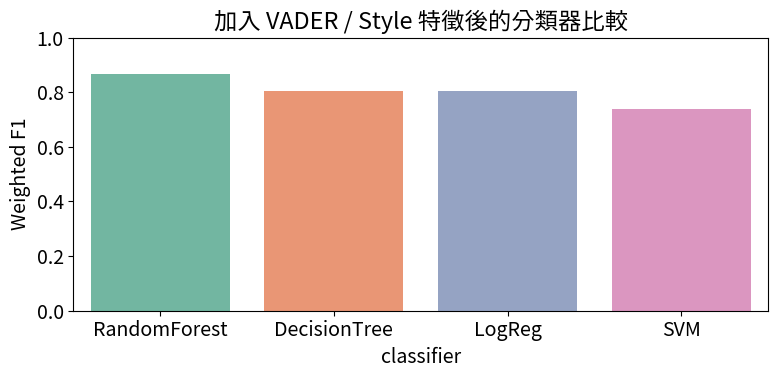

In [17]:
# ── Part 5：TF-IDF+NER+Sentiment特徵上，再加入VADER(+Empath)與文字表達Style特徵 ──────────────────────
# ------------------------------------------------------------------
# 1. 透過卡方檢定 (chi-square) 找出「假新聞 > 真新聞」最具區辨力的 n-gram
# ------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import numpy as np, pandas as pd, re
from tqdm import tqdm

# （1）建一個詞袋模型（unigram+bigram，過濾英文停用字, min_df=5 避免太稀有）
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5)
X_bow = cv.fit_transform(data['clean_text'])
feature_names = np.array(cv.get_feature_names_out())

# （2）做卡方檢定；label=1 代表假新聞
chi_scores, _ = chi2(X_bow, data['label'])

# （3）只保留在假新聞出現次數 > 真新聞的詞，再取前 30 名
fake_mask = (X_bow[data['label'].values==1].sum(axis=0) >
             X_bow[data['label'].values==0].sum(axis=0)).A1
candidate_words = feature_names[fake_mask]
candidate_scores= chi_scores[fake_mask]

top_k = 30
top_idx = np.argsort(candidate_scores)[::-1][:top_k]
auto_clickbait = set(candidate_words[top_idx])

print(f"🔍 自動偵測到 {len(auto_clickbait)} 個假新聞高相關詞（前 {top_k}）：")
print(sorted(auto_clickbait))

# ------------------------------------------------------------------
# 2. 建立 VADER / Empath / Style 特徵（含「動態 click-bait」）
# ------------------------------------------------------------------
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
try:
    from empath import Empath
    lexicon = Empath(); use_empath = True
except ModuleNotFoundError:
    use_empath = False

tqdm.pandas()

# 2-1 VADER
vader = SentimentIntensityAnalyzer()
vader_df = (data['text'].progress_apply(vader.polarity_scores)
                       .apply(pd.Series).add_prefix('vader_'))
print("\n🧠 VADER 情緒推動特徵（前幾筆）：")
print(vader_df.head())

# 2-2 Empath（選擇幾個常用情緒社會面向）
if use_empath:
    empath_raw = data['text'].progress_apply(lambda t: lexicon.analyze(t, normalize=True))
    empath_keep = ['positive_emotion','negative_emotion','anger','sadness',
                   'fear','politics','money','fun','love']
    empath_df = (pd.DataFrame(empath_raw.tolist())
                   [empath_keep].add_prefix('empath_'))

    print("\n🎯 NRC-Empath 情緒向量（前幾筆）：")
    print(empath_df.head())
else:
    empath_df = pd.DataFrame(index=data.index)   # 空 DF
    print("\n⚠️ 未啟用 Empath（需 pip install empath）")

# 2-3 Style features（大寫比例 / ! 密度 / 自動 click-bait 命中率）
def style_feats(txt:str):
    L = max(len(txt),1)
    txt_low = txt.lower()
    hit_cnt = sum(1 for w in auto_clickbait if w in txt_low)
    return pd.Series({
        'caps_ratio'      : sum(c.isupper() for c in txt)/L,
        'excl_ratio'      : txt.count('!')/L,
        'clickbait_ratio' : hit_cnt / len(auto_clickbait)
    })

style_df = data['text'].progress_apply(style_feats)

print("\n📝 文字表達方式特徵（大寫比例 / 感嘆號密度 / Click-bait 命中率）")
print(style_df.describe())

print("\n📊 假新聞與真新聞的 Style 特徵平均比較：")
print(pd.concat([style_df, data['label']], axis=1)
        .groupby('label').mean()
        .rename(index={0: "真新聞", 1: "假新聞"}))

# ------------------------------------------------------------------
# 3. 把新特徵接到既有 X_features（TF-IDF + NER + Best-Sentiment）
# ------------------------------------------------------------------
X_final = pd.concat([X_features, vader_df, empath_df, style_df], axis=1)
y_final = data['label']
print("🔢 新增後特徵維度 :", X_final.shape)

# ------------------------------------------------------------------
# 4. 四個分類器 × 5-fold 交叉驗證
# ------------------------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from tabulate import tabulate
import seaborn as sns, matplotlib.pyplot as plt

clfs = {
    "LogReg"      : LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "SVM"         : SVC(probability=True),
    "RandomForest": RandomForestClassifier(random_state=42)
}
# clfs = {
#     "RandomForest": RandomForestClassifier(random_state=42)
# }

kf = StratifiedKFold(5, shuffle=True, random_state=42)
rows = []

for name, base in clfs.items():
    y_t, y_p, f1s = [], [], []
    for tr, te in kf.split(X_final, y_final):
        mdl = clone(base).fit(X_final.iloc[tr], y_final.iloc[tr])
        pred = mdl.predict(X_final.iloc[te])
        y_t.extend(y_final.iloc[te]); y_p.extend(pred)
        f1s.append(f1_score(y_final.iloc[te], pred, average='weighted'))
    print(f"\n=== {name} 報告 (加 VADER / Style) ===")
    print(classification_report(y_t, y_p, target_names=['真新聞','假新聞'], digits=2))
    rows.append({"classifier": name, "f1_weighted": np.mean(f1s)})

res_df = pd.DataFrame(rows).sort_values('f1_weighted', ascending=False)
print("\n📊  加 VADER / Style / 動態 Click-bait 後分類器比較")
print(tabulate(res_df, headers="keys", tablefmt="fancy_grid"))

best_cls = res_df.iloc[0]
print(f"\n🏆  新最佳模型：{best_cls['classifier']}  (Weighted F1 = {best_cls['f1_weighted']:.4f})")

# （可選）長條圖
plt.figure(figsize=(8,4))
sns.barplot(x='classifier', y='f1_weighted', data=res_df, palette='Set2')
plt.title('加入 VADER / Style 特徵後的分類器比較')
plt.ylabel('Weighted F1')
plt.ylim(0,1); plt.tight_layout(); plt.show()


+ 結論：引入VADER情緒分析與文字風格特徵，以強化假新聞與真新聞的語言表徵差異，經以上模型測試，**使用「NER+情緒+TFIDF+VADER+STYLE」特徵的結果最好**，`最佳分類器：RandomForest`，`Weighted F1 =0.8675 `。
+ 從VADER特徵結果可見，假新聞整體偏向產生較高的負向情緒分數與極端情感（compound 分數較負），顯示假新聞傾向以情緒性語言激發讀者反應。另一方面，文字表達方式方面的比較顯示，假新聞在大寫字母使用比例（caps_ratio）、感嘆號密度（excl_ratio）、以及 clickbait 關鍵詞命中率（clickbait_ratio）均高於真新聞，顯示假新聞常透過誇張標題與視覺強調以吸引注意力。

#### F. 使用「NER+情緒+SBERT」來辨識真假新聞
+ 利用SBERT向量化方式與步驟D的TFIDF比較，，再加上`4個分類器(LogisticRegression、DecisionTree、SVM、RandomForest)`評估最佳結果。
+ 經前測結果，採用此模型`sentence-transformers/paraphrase-MiniLM-L6-v2`進行。
1. 使用all-MiniLM-L6-v2，最佳分類器為：RandomForest，Weighted F1 = 0.7197
2. 使用sentence-transformers/paraphrase-MiniLM-L6-v2，最佳分類器為：LogReg，Weighted F1 = 0.7467

Batches:   0%|          | 0/1171 [00:00<?, ?it/s]

📐 向量維度： (37448, 384)

=== LogReg 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.83      0.82      0.82     18466
         假新聞       0.82      0.84      0.83     18982

    accuracy                           0.83     37448
   macro avg       0.83      0.83      0.83     37448
weighted avg       0.83      0.83      0.83     37448


=== DecisionTree 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.69      0.69      0.69     18466
         假新聞       0.70      0.70      0.70     18982

    accuracy                           0.70     37448
   macro avg       0.70      0.70      0.70     37448
weighted avg       0.70      0.70      0.70     37448


=== SVM 分類結果（5-fold） ===
              precision    recall  f1-score   support

         真新聞       0.87      0.85      0.86     18466
         假新聞       0.86      0.87      0.86     18982

    accuracy                           0.86     37448
   macro avg     

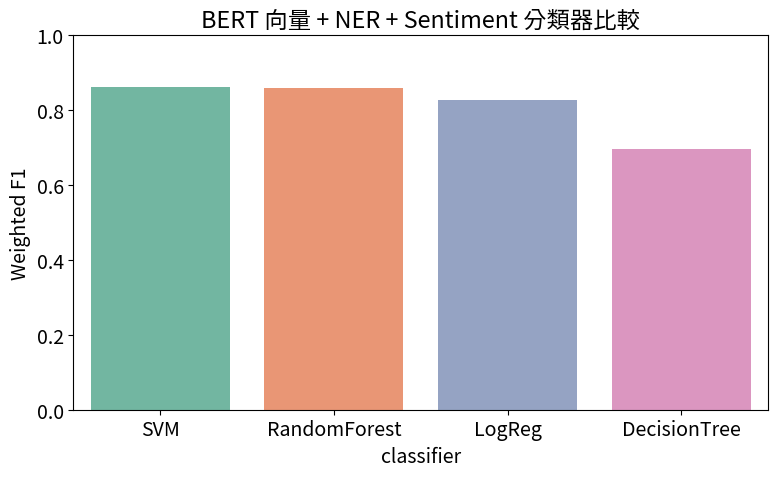

In [30]:
# ────── Part 6：NER+Sentiment特徵+SBERT向量化 ──────────────────────
# ▍1. SBERT 向量化
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')  # 可改其他如 'paraphrase-MiniLM-L6-v2'
sbert_embeddings = model.encode(data['clean_text'].fillna(''), show_progress_bar=True)

sbert_df = pd.DataFrame(sbert_embeddings, index=data.index)
sbert_df.columns = sbert_df.columns.astype(str)
print("📐 向量維度：", sbert_df.shape)

# ▍2. 合併其他特徵（NER + Sentiment）
ner_df    = data_with_ner[['PER', 'ORG', 'LOC']].copy()
senti_df  = data[['sentiment_score']]
X_sbert   = pd.concat([sbert_df, ner_df, senti_df], axis=1)
y_target  = data['label']

# ▍3. 建立分類器組合
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.base import clone
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

classifiers = {
    "LogReg"       : LogisticRegression(max_iter=1000),
    "DecisionTree" : DecisionTreeClassifier(),
    "SVM"          : SVC(probability=True),
    "RandomForest" : RandomForestClassifier(random_state=42)
}
# classifiers = {
#     "RandomForest" : RandomForestClassifier(random_state=42)
# }

# ▍4. Cross-validation 比較表現
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for clf_name, clf_model in classifiers.items():
    print(f"\n=== {clf_name} 分類結果（5-fold） ===")
    y_all_true, y_all_pred, f1s = [], [], []

    for train_idx, test_idx in kf.split(X_sbert, y_target):
        X_train, X_test = X_sbert.iloc[train_idx], X_sbert.iloc[test_idx]
        y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]

        clf = clone(clf_model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_all_true.extend(y_test)
        y_all_pred.extend(y_pred)
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    print(classification_report(y_all_true, y_all_pred, target_names=["真新聞", "假新聞"], digits=2))

    results.append({
        "classifier": clf_name,
        "f1_weighted": np.mean(f1s)
    })

# ▍5. 顯示比較結果
result_df = pd.DataFrame(results).sort_values(by='f1_weighted', ascending=False).reset_index(drop=True)

print("\n📊 SBERT + NER + Sentiment 分類器比較：")
print(tabulate(result_df, headers="keys", tablefmt="fancy_grid"))

best = result_df.iloc[0]
print(f"\n🏆 最佳分類器為：{best['classifier']}，weighted F1 = {best['f1_weighted']:.4f}")

# ▍6. 視覺化結果
plt.figure(figsize=(8,5))
sns.barplot(x='classifier', y='f1_weighted', data=result_df, palette='Set2')
plt.title("BERT 向量 + NER + Sentiment 分類器比較")
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


+ 結論：表現成果沒有步驟E使用「NER+情緒+TFIDF+VADER+文字Style」的好，`最佳分類器：SVM`，`Weighted F1 =0.8612 `。

#### **G. 最佳多特徵模型為：使用「NER+情緒分數+TFIDF+VADER+文字Style」最好**
`最佳分類器：RandomForest`，`Weighted F1 =0.8675 `。利用此結果往下進行Bertopic作業

## 三、主題模型：BERTopic 
+ 依最佳向量化策略(TFIDF+Style)建立HDBSCAN聚類，並輸出「真假比例最高/最低」主題與關鍵字。
+ 步驟：使用最佳向量化結果(TFIDF+VADER+文字Style)→BERTopic分群→疊加真假標籤→看每個主題哪邊假新聞高、哪邊真新聞高，這樣就能得到：
  1. 假新聞最常見的主題有哪些?
  2. 真新聞裡哪些主題特別突出?
  3. 各主題的代表關鍵詞

2025-06-17 14:41:38,708 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-17 14:42:22,251 - BERTopic - Dimensionality - Completed ✓
2025-06-17 14:42:22,254 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-17 14:42:25,312 - BERTopic - Cluster - Completed ✓
2025-06-17 14:42:25,321 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-17 14:42:37,322 - BERTopic - Representation - Completed ✓


▶ 各 Topic 真／假筆數與假新聞比例 (前 10)：


label_name,Fake,True,Total,Fake_Ratio
topic,,,,
339,32,0,32,1.0
227,57,0,57,1.0
347,30,0,30,1.0
359,17,0,17,1.0
249,51,0,51,1.0
278,43,0,43,1.0
329,34,0,34,1.0
280,43,0,43,1.0
243,52,0,52,1.0



🟥 假新聞高比例主題關鍵字 TOP 30


,topic,word,c_tf_idf,Fake_Ratio
2800,280,american male,0.168297,1.0
2490,249,rick perry,0.167805,1.0
2491,249,perry,0.163312,1.0
3200,320,birthright,0.153495,1.0
3201,320,birthright citizenship,0.151025,1.0
...,...,...,...,...
2479,247,gottlieb said,0.013787,0.0
2726,272,kenyan,0.012094,0.0
2727,272,raila,0.010129,0.0
2728,272,kisumu,0.010129,0.0



🟦 真新聞高比例主題關鍵字 TOP 30


,topic,word,c_tf_idf,Fake_Ratio
1630,163,joe exotic,0.267160,0.0
1631,163,exotic,0.262834,0.0
1632,163,pardoned,0.256336,0.0
2290,229,wildfire,0.150028,0.0
1280,128,hank aaron,0.136449,0.0
...,...,...,...,...
3297,329,militia,0.011780,1.0
2548,254,leaving american,0.011751,1.0
2549,254,unemployment benefit,0.011611,1.0
3298,329,wildlife,0.011011,1.0


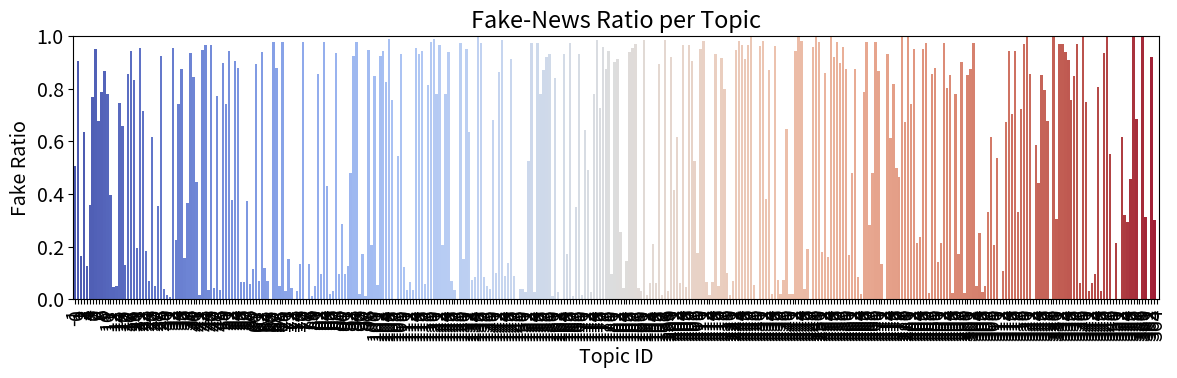

In [ ]:
# -------- 1. 選擇向量化方式 -------------------------------------Part 4 / 5 / 6 結果輸入
VEC_CHOICE = "tfidf_style"       # ← 輸入 # Part 4- "tfidf" / Part 5- "tfidf_style" / Part 6- "sbert"
texts = data['clean_text'].fillna('')

if VEC_CHOICE == "tfidf":
    vec_model = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")
    embeddings = vec_model.fit_transform(texts)

elif VEC_CHOICE == "tfidf_style":
    if "X_final" not in globals():
        raise RuntimeError("⚠️ 找不到 X_final，請先執行 Part 5 建立特徵")
    embeddings = X_final.values

elif VEC_CHOICE == "sbert":
    emb_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings = emb_model.encode(texts, show_progress_bar=True)

else:
    raise ValueError("VEC_CHOICE 僅能為 'tfidf' / 'tfidf_style' / 'sbert'")

# -------- 2. 建立 BERTopic 模型 ----------------------------------
topic_model = BERTopic(
    embedding_model=None if VEC_CHOICE.startswith("tfidf") else emb_model,
    hdbscan_model=HDBSCAN(min_cluster_size=10, min_samples=30),
    vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words="english"),
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts, embeddings)
data['topic'] = topics

# ✅ 防呆：確認是否有有效主題（非 -1）
valid_topics = [t for t in set(topics) if t != -1]
if len(valid_topics) == 0:
    print("⚠️ 無有效主題（全部為 outlier），請檢查資料筆數或降低 min_cluster_size 設定。")
else:
    # -------- 3. 主題 × 真／假 分佈 -------------------------------
    data['label_name'] = data['label'].map({0: "True", 1: "Fake"})
    topic_dist = (data.groupby(['topic', 'label_name']).size().unstack(fill_value=0))
    topic_dist['Total'] = topic_dist.sum(axis=1)
    topic_dist['Fake_Ratio'] = topic_dist['Fake'] / topic_dist['Total']

    print("▶ 各 Topic 真／假筆數與假新聞比例 (前 10)：")
    display(topic_dist.sort_values('Fake_Ratio', ascending=False).head(10))

    # -------- 4. 取主題關鍵字並依真假比例排序 ----------------------
    kw_rows = []
    for tid, word_scores in topic_model.get_topics().items():
        if tid == -1:
            continue
        for word, score in word_scores:
            kw_rows.append({"topic": tid, "word": word, "c_tf_idf": score})

    kw_df = pd.DataFrame(kw_rows)

    merged_kw = kw_df.merge(topic_dist.reset_index(), on="topic")

    fake_top_kw = (merged_kw.sort_values(['Fake_Ratio', 'c_tf_idf'], ascending=[False, False])
                            .groupby('topic')
                            .head(30))

    true_top_kw = (merged_kw.sort_values(['Fake_Ratio', 'c_tf_idf'], ascending=[True, False])
                            .groupby('topic')
                            .head(30))

    print("\n🟥 假新聞高比例主題關鍵字 TOP 30")
    display(fake_top_kw[['topic', 'word', 'c_tf_idf', 'Fake_Ratio']])

    print("\n🟦 真新聞高比例主題關鍵字 TOP 30")
    display(true_top_kw[['topic', 'word', 'c_tf_idf', 'Fake_Ratio']])

    # -------- 5. 視覺化每個主題的假新聞比例 ------------------------
    plt.figure(figsize=(12, 4))
    sns.barplot(x=topic_dist.index, y=topic_dist['Fake_Ratio'], palette="coolwarm")
    plt.title("Fake-News Ratio per Topic")
    plt.ylabel("Fake Ratio")
    plt.xlabel("Topic ID")
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


+ **結論**
+ 透過BERTopic主題建模，採用加入情緒與Style特徵的向量進行分析，揭露假新聞與真新聞分布於主題空間的顯著差異。結果顯示，多個主題呈現高度偏向假新聞（Fake Ratio = 1.0），其中包含與政治人物（如 rick perry、american male）或具爭議性的主張（如 birthright citizenship）相關之主題，凸顯假新聞常聚焦於特定敏感議題以吸引讀者注意。
+ 真新聞比例較高之主題則較多涵蓋中性事件與資訊報導（如 joe exotic、wildfire、pardoned），顯示其內容傾向客觀描述且情緒操弄程度較低。
+ 從「每個主題的假新聞比例視覺化圖」可進一步觀察主題分布的極化現象，其中部分主題集中呈現極高或極低的假新聞比例，驗證主題模型能有效捕捉新聞真偽傾向。
+ 綜合上述，加入情緒與Style向量特徵後所建構之主題模型，提升了主題Topic的字彙區辨能力，也有助於從主題角度理解真假新聞常出現的字彙。

## 四、LLM ##

三個本地模型分別扮演不同角色：
- logic_llm：邏輯面判斷者(LLaMA)
- debater_llm：辯論立場提出者(Mistral)
- judge_llm：原始仲裁者，同時也負責最終決策(Phi-3)


這三個模型會同時針對同一則訊息進行判斷，輸出 verdict, confidence, reason 三欄 JSON

In [32]:
from langchain_community.chat_models import ChatOllama  # 使用 Ollama 封裝的 LLaMA 模型
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.prompts import PromptTemplate

# 定義輸出結構


class MessageClassification(BaseModel):
    verdict: str = Field(
        description="Verdict whether the message is Real or Fake")
    confidence: str = Field(
        description="Confidence level of the judgment (e.g., High, Medium, Low)")
    reason: str = Field(description="Brief explanation of the judgment")


# 使用本地 LLaMA 模型
judge_llm = ChatOllama(model="llama3:8B")
logic_llm = ChatOllama(model="phi3:3.8B")
debater_llm = ChatOllama(model="mistral:7B")

# Json 輸出格式解析器
parser = JsonOutputParser(pydantic_object=MessageClassification)
format_instructions = parser.get_format_instructions()


# 單一 LLM 推理的 Prompt
llm_prompt = PromptTemplate.from_template(
    """
You are a professional fact-checker. Analyze the following message and determine if it is real or fake.

Message:
\"\"\"{message}\"\"\"

Respond **strictly** in the following JSON format:

{{
  "verdict": "",        // Only "Real" or "Fake"
  "confidence": "",     // Only "High", "Medium", or "Low"
  "reason": ""          // A short explanation (1-2 sentences)
}}

❗ Instructions:
- Your response MUST be valid JSON. Do not include any other text.
- Do NOT wrap the output in markdown (e.g., do NOT use ```json or any backticks).
- Do NOT explain your answer outside the JSON.
- Output only the JSON object with exactly three string fields: verdict, confidence, and reason.
"""
)

# 讓 judge_llm 匯總所有模型觀點的 Prompt
summary_prompt = PromptTemplate.from_template(
    """
You are the final arbiter. Three experts have evaluated the message. Please summarize their opinions and give your final decision.

Message:
\"\"\"{message}\"\"\"

Expert 1 (Logic-focused model):
{logic_opinion}

Expert 2 (Debate-focused model):
{debate_opinion}

Expert 3 (Your own opinion):
{your_opinion}

Now summarize the opinions, resolve any conflicts, and provide a final classification in this JSON format:
{format_instructions}
"""
)

仲裁模型角色說明：
輸入: 原始訊息 data[text]

對象: llama3:8B、phi3:3.8B、mistral:7B

得到: 三個模型的觀點

見整合這三份觀點，根據summary prompt回傳一組新的 JSON作為最後答案


In [33]:
import pandas as pd
import concurrent.futures
import re
import json

def extract_json(text: str) -> dict:
    try:
        
        # 找出第一組結構為 { ... } 的JSON區塊
        match = re.search(r'{[\s\S]*?}', text)
        if not match:
            print("⚠️ 無有效 JSON 區塊，跳過此輸出。")
            print("原始輸出：", text)
            return {
                "verdict": "Unknown",
                "confidence": "Low",
                "reason": "Model did not return valid JSON block."
            }
        json_str = match.group()
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"\n JSON 解析失敗：{e}")
        print("原始輸出：", text)
        return {
            "verdict": "Unknown",
            "confidence": "Low",
            "reason": "Model did not return valid JSON."
        }

def call_llm(llm, prompt):
    response = llm.invoke(prompt)
    return response.content if hasattr(response, "content") else response

# 定義分析函式
def analyze_message_with_multi_llm(message: str):
    logic_input = llm_prompt.format(message=message, format_instructions=format_instructions)
    debate_input = llm_prompt.format(message=message, format_instructions=format_instructions)
    judge_input = llm_prompt.format(message=message, format_instructions=format_instructions)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(call_llm, logic_llm, logic_input): "logic",
            executor.submit(call_llm, debater_llm, debate_input): "debate",
            executor.submit(call_llm, judge_llm, judge_input): "judge"
        }
        results = {}
        for future in concurrent.futures.as_completed(futures):
            key = futures[future]
            results[key] = future.result()

    summary_input = summary_prompt.format(
        message=message,
        logic_opinion=results["logic"],
        debate_opinion=results["debate"],
        your_opinion=results["judge"],
        format_instructions=format_instructions
    )

    final_response = judge_llm.invoke(summary_input)
    result = extract_json(final_response.content)
    return result

# 6/17 batch實作
# ========== Batch呼叫llm ==========

def batch_call_llm(llm, messages: list, batch_size: int, model_name: str) -> list:
    outputs = []
    for i in tqdm(range(0, len(messages), batch_size), desc=f"Batching {model_name}"):
        batch = messages[i:i+batch_size]
        prompts = [llm_prompt.format(message=msg, format_instructions=format_instructions) for msg in batch]
        results = llm.batch(prompts)
        outputs.extend([res.content if hasattr(res, "content") else res for res in results])
    return outputs

# ========== batch主流程 ==========
# 先粗略根據模型餐數量大小分batch量
def process_data_in_batches(df: pd.DataFrame, batch_logic=32, batch_debate=16, batch_judge=8) -> pd.DataFrame:
    messages = df["text"].tolist()
    logic_results = batch_call_llm(logic_llm, messages, batch_logic, model_name="logic_llm")
    debate_results = batch_call_llm(debater_llm, messages, batch_debate, model_name="debater_llm")
    judge_results = batch_call_llm(judge_llm, messages, batch_judge, model_name="judge_llm")

    final_results = []
    for i in tqdm(range(len(messages)), desc="Final summarization"):
        summary_input = summary_prompt.format(
            message=messages[i],
            logic_opinion=logic_results[i],
            debate_opinion=debate_results[i],
            your_opinion=judge_results[i],
            format_instructions=format_instructions
        )
        final_response = judge_llm.invoke(summary_input)
        parsed = extract_json(final_response.content)
        final_results.append(parsed)

    return pd.DataFrame(final_results)

# ========== encode ==========

def encode_verdict(verdict: str) -> int:
    if verdict.strip().lower() == 'real':
        return 1
    elif verdict.strip().lower() == 'fake':
        return 0
    else:
        return 2 # 代表 Unknown 或其他無效輸入

def encode_confidence(conf: str) -> int:
    mapping = {'low': 0, 'medium': 1, 'high': 2}
    return mapping.get(conf.strip().lower(), 1)  # 預設給信心程度1

In [34]:
# import random

# # 觀察測試用!!!
# sample_texts = data['text'].sample(10, random_state=42)

# for i, text in enumerate(sample_texts):
#     result = analyze_message_with_multi_llm(text)
#     print("推論結果：", result)

In [35]:
# 所需時間太長，故使用較小資料集

# === 隨機抽樣 200 筆原始資料 ===
sampled_indices = data.sample(n=200, random_state=42).index

sampled_data = data.loc[sampled_indices]
X_final_sampled = X_final.loc[sampled_indices]
y_final_sampled = y_final.loc[sampled_indices]

### 根據 LLM response 新增資料欄位 ###

經過prompt定義、JSON過濾器，每一筆資料預期得到類似以下結構response:
{
    "verdict": "Real", 
    "confidence": "High", 
    "reason": ""
}

提出verdict、confidence欄位並各自做encode，再新增進要拿來訓練的資料做為新的欄位

In [ ]:
# multi-LLM
# llm_results = data['text'].progress_apply(analyze_message_with_multi_llm)
# llm_df = pd.DataFrame(llm_results.tolist())

# 改成批次處理版本process_data_in_batches
llm_df = process_data_in_batches(sampled_data)



Final summarization:   5%|▌         | 10/200 [03:35<1:08:45, 21.71s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 3 column 116 (char 135)
原始輸出： Here is the summary of opinions and my final decision:

{
  "properties": {
    "verdict": {"title": "Verdict", "description": "Verdict whether the message is Real or Fake", "type": "string"},
    "confidence": {"title": "Confidence", "description": "Confidence level of the judgment (e.g., High, Medium, Low)", "type": "string"},
    "reason": {"title": "Reason", "description": "Brief explanation of the judgment", "type": "string"}
  },
  "required": ["verdict", "confidence", "reason"]
}

{
  "verdict": "Real",
  "confidence": "High",
  "reason": "The message's content aligns accurately with known facts from Reuters about the Trump administration making a final legal argument for its travel ban before the Supreme Court. All three experts agree that the message is real, and I concur with their assessment."
}

Explanation: After reviewing the opinions of the three experts, it is clear that they all believe the message

Final summarization:  18%|█▊        | 36/200 [14:57<1:08:55, 25.22s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 7 column 6 (char 159)
原始輸出： Here is the summary of opinions and the final classification in JSON format:

{
  "properties": {
    "verdict": {
      "title": "Verdict",
      "description": "Verdict whether the message is Real or Fake",
      "type": "string"
    },
    "confidence": {
      "title": "Confidence",
      "description": "Confidence level of the judgment (e.g., High, Medium, Low)",
      "type": "string"
    },
    "reason": {
      "title": "Reason",
      "description": "Brief explanation of the judgment",
      "type": "string"
    }
  },
  "required": ["verdict", "confidence", "reason"]
}

{
  "verdict": "Real",
  "confidence": "High",
  "reason": "After reviewing the opinions of three experts, it is clear that all three agree that the message is real. The first expert's opinion was not directly related to the message, but the other two experts' opinions were unanimous in classifying the message as 'Real'. Therefore, our final

Final summarization:  22%|██▏       | 43/200 [17:47<1:07:19, 25.73s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 7 column 6 (char 159)
原始輸出： Here is the summarized output in JSON format:

```json
{
  "properties": {
    "verdict": {
      "title": "Verdict",
      "description": "Verdict whether the message is Real or Fake",
      "type": "string"
    },
    "confidence": {
      "title": "Confidence",
      "description": "Confidence level of the judgment (e.g., High, Medium, Low)",
      "type": "string"
    },
    "reason": {
      "title": "Reason",
      "description": "Brief explanation of the judgment",
      "type": "string"
    }
  },
  "required": ["verdict", "confidence", "reason"],
  "verdict": [
    {"Real", "High", "The statement is directly quoted from Reuters news agency, a reputable international news organization."},
    {"Real", "High", "The message appears to be a genuine news article from Reuters, a reputable news agency, and the quote matches Philip Hammond's public statements on the topic."}
  ]
}
```

As there are no conflicts betw

Final summarization:  22%|██▎       | 45/200 [18:30<1:02:32, 24.21s/it]


 JSON 解析失敗：Expecting ':' delimiter: line 3 column 27 (char 48)
原始輸出： Here is a summary of the opinions and my final decision:

**Summary:**

Expert 1's opinion is unclear due to their use of nonsensical language, making it impossible to determine their verdict.

Expert 2's verdict is "Unknown" with low confidence, citing lack of evidence or reliable sources. This opinion is reasonable, but not definitive.

Expert 3's verdict is "Real" with high confidence, based on the message's tone and style being consistent with online discussions.

**Conflict Resolution:**

I will rely more heavily on Expert 2's assessment that there is a lack of sufficient evidence or reliable sources to determine the accuracy of the message. However, I will also consider Expert 3's opinion that the message appears genuine based on its tone and style.

**Final Classification:**

Here is my final decision in JSON format:
```
{
    "properties": {
        "verdict": {"Real"},
        "confidence": {"Medium"},
     

Final summarization:  30%|███       | 60/200 [24:20<55:30, 23.79s/it]  


 JSON 解析失敗：Expecting ',' delimiter: line 7 column 6 (char 159)
原始輸出： Here is the summary of the opinions and the final classification:

```
{
  "properties": {
    "verdict": {
      "title": "Verdict",
      "description": "Verdict whether the message is Real or Fake",
      "type": "string"
    },
    "confidence": {
      "title": "Confidence",
      "description": "Confidence level of the judgment (e.g., High, Medium, Low)",
      "type": "string"
    },
    "reason": {
      "title": "Reason",
      "description": "Brief explanation of the judgment",
      "type": "string"
    }
  },
  "required": ["verdict", "confidence", "reason"]
},
{
  "verdict": "Real",
  "confidence": "High",
  "reason": "After reviewing the opinions of the three experts, it appears that all three agree that the message is genuine. Expert 1's analysis was irrelevant to the judgment, but Experts 2 and 3 both concluded that the message is real due to its consistent tone and language with Ricky Davila's public

Final summarization:  36%|███▋      | 73/200 [28:51<45:03, 21.29s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 7 column 6 (char 159)
原始輸出： Here is the summary of opinions and the final classification:

```json
{
  "properties": {
    "verdict": {
      "title": "Verdict",
      "description": "Verdict whether the message is Real or Fake",
      "type": "string"
    },
    "confidence": {
      "title": "Confidence",
      "description": "Confidence level of the judgment (e.g., High, Medium, Low)",
      "type": "string"
    },
    "reason": {
      "title": "Reason",
      "description": "Brief explanation of the judgment",
      "type": "string"
    }
  },
  "required": ["verdict", "confidence", "reason"]
},
{
  "verdict": "Fake",
  "confidence": "High",
  "reason": "The message appears to be fabricated as there is no evidence of such an exchange between Bernie Sanders and Jake Tapper on CNN. Additionally, the claims about single-payer health care being rejected in Vermont and California are not accurate."
}
```

In this case, I agree with Expert 3 tha

Final summarization:  41%|████      | 82/200 [31:53<38:22, 19.51s/it]


 JSON 解析失敗：Expecting ':' delimiter: line 3 column 21 (char 38)
原始輸出： Based on the opinions provided by the three experts, I will summarize their views and provide a final classification in JSON format:

{
"properties": {
  "verdict": {"Real"},
  "confidence": {"High"},
  "reason": {
    "The statement compares the popularity of candidates in multiple elections and presents a logical conclusion based on historical data. The message is referencing real events (the presidential elections) and a valid point about voting for the lesser of two evils."
  }
}

The verdict is unanimous among all three experts: the message is classified as "Real".


Final summarization:  48%|████▊     | 97/200 [36:53<26:04, 15.19s/it]

⚠️ 無有效 JSON 區塊，跳過此輸出。
原始輸出： Based on the opinions provided by the three experts, I will summarize their views and provide a final classification in the JSON format.

Here is the summary:

**Verdict**: Fake
**Confidence**: High
**Reason**: The statement's tone and language suggest it is an oversimplification or a conspiracy theory. Additionally, the idea that governments allow high-income earners to pay 'Next to No Tax' without any consequences is highly unlikely.


Final summarization:  54%|█████▍    | 108/200 [41:19<34:22, 22.42s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 7 column 4 (char 147)
原始輸出： Here is the summary and final classification:

{
"properties": {
  "verdict": {
    "title": "Verdict",
    "description": "Verdict whether the message is Real or Fake",
    "type": "string"
  },
  "confidence": {
    "title": "Confidence",
    "description": "Confidence level of the judgment (e.g., High, Medium, Low)",
    "type": "string"
  },
  "reason": {
    "title": "Reason",
    "description": "Brief explanation of the judgment",
    "type": "string"
  }
},
"required": ["verdict", "confidence", "reason"]
}

{
"verdict": "Fake",
"confidence": "High",
"reason": "The message appears to be making an unfair comparison between Jay's actions in the 80s and Trump's business dealings, and lacks specific evidence or credible sources to support its claims."
}


Final summarization:  55%|█████▍    | 109/200 [41:47<36:23, 24.00s/it]

⚠️ 無有效 JSON 區塊，跳過此輸出。
原始輸出： Based on the opinions provided by the three experts, I summarize their views and resolve any conflicts as follows:

**Verdict:** Real
**Confidence:** High
**Reason:** The article appears to be a factual news report from Reuters, and its content matches the style and format of typical news articles. The language used is professional, and the quotes provided are attributed to specific individuals.

Here's how I arrived at this conclusion:

* Expert 1 did not provide a clear verdict or confidence level, so their opinion is not considered in this decision.
* Expert 2 concluded that the text is "Real" with high confidence, which aligns with my own analysis. Their reason for this judgment was that the text appears to be a factual news article about Rex Tillerson's attempts to address skepticism within the State Department regarding his leadership and reorganization plans, as reported by Reuters.
* Expert 3 also concluded that the text is "Real" with high confidenc

Final summarization:  69%|██████▉   | 138/200 [51:52<23:23, 22.64s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 7 column 4 (char 147)
原始輸出： After reviewing the opinions from the three experts, I have summarized their findings and resolved any conflicts to provide a final classification. Here is the output in JSON format:

{
"properties": {
  "verdict": {
    "title": "Verdict",
    "description": "Verdict whether the message is Real or Fake",
    "type": "string"
  },
  "confidence": {
    "title": "Confidence",
    "description": "Confidence level of the judgment (e.g., High, Medium, Low)",
    "type": "string"
  },
  "reason": {
    "title": "Reason",
    "description": "Brief explanation of the judgment",
    "type": "string"
  }
},
"required": ["verdict", "confidence", "reason"]
},

{
"verdict": "Real",
"confidence": "High",
"reason": "The statement reflects a commonly held view about the impact of trickle-down economics, and it accurately describes the current budget deficit and economic trends since 2016."
}

Note: As per the schema provided, I hav

Final summarization:  72%|███████▏  | 143/200 [53:45<22:58, 24.19s/it]


 JSON 解析失敗：Expecting ',' delimiter: line 3 column 116 (char 135)
原始輸出： Based on the opinions provided by the three experts, I summarize their opinions and resolve any conflicts to provide a final classification in JSON format:

```
{
  "properties": {
    "verdict": {"title": "Verdict", "description": "Verdict whether the message is Real or Fake", "type": "string"},
    "confidence": {"title": "Confidence", "description": "Confidence level of the judgment (e.g., High, Medium, Low)", "type": "string"},
    "reason": {"title": "Reason", "description": "Brief explanation of the judgment", "type": "string"}
  },
  "required": ["verdict", "confidence", "reason"]
},
{
  "verdict": "Real",
  "confidence": "High",
  "reason": "The information corresponds to a Reuters news article published on August 20, 2017, titled 'Spain to push EU leaders for better counter-terrorism coordination'. The content of the message closely matches that of the original article."
},
{
  "verdict": "Real",
  "confid

Final summarization:  78%|███████▊  | 155/200 [58:20<18:10, 24.23s/it]

⚠️ 無有效 JSON 區塊，跳過此輸出。
原始輸出： Based on the opinions from Experts 1-3, I will summarize their views and provide a final classification.

**Summary:**

Expert 1 (Logic-focused model) did not submit an opinion.

Expert 2 (Debate-focused model) concluded that the message is "Real" with a high confidence level. Their reason was that the message contains quotes from reputable sources such as Sports Business Journal and Rasmussen Reports, and it references specific declines in ratings for various networks.

Expert 3 (Your own opinion) also concluded that the message is "Real" with a high confidence level. Their reason was that multiple reputable sources (e.g., Sports Business Journal) are cited to support the claim about TV executives discussing canceling Thursday Night NFL games, and the article includes a letter from a Steelers fan that is consistent with public opinion on the topic.

**Final Classification:**

{"verdict": "Real", "confidence": "High", "reason": "The message contains quotes f

Final summarization:  82%|████████▏ | 164/200 [1:01:57<11:37, 19.36s/it]

⚠️ 無有效 JSON 區塊，跳過此輸出。
原始輸出： Based on the opinions provided by Experts 1-3, I will summarize their verdicts and resolve any conflicts.

**Verdict:** Real
**Confidence:** High
**Reason:** The article appears to be a genuine news report from Reuters, a well-established and reputable news agency. The language used is professional and informative, and the inclusion of specific details and quotes adds to its credibility.


Final summarization:  96%|█████████▌| 191/200 [1:11:18<02:56, 19.66s/it]

⚠️ 無有效 JSON 區塊，跳過此輸出。
原始輸出： Here is the summary of opinions:

**Verdict**: Real
**Confidence**: High
**Reason**: The message appears to be a quote from a real news article or official government report, with numbers that match reported figures from US Customs and Border Protection and other reputable sources.

As there are no conflicts between the experts' opinions, I will adopt their consensus verdict.


Final summarization: 100%|██████████| 200/200 [1:14:33<00:00, 22.37s/it]


AttributeError: 'list' object has no attribute 'strip'

In [39]:
# clean and 
def clean_verdict(v):
    if isinstance(v, list):
        # 尋找第一個非空字串
        for item in v:
            if isinstance(item, str) and item.strip():
                return item
        return 'Unknown'
    elif isinstance(v, str):
        return v
    else:
        return 'Unknown'
    
def clean_confidence(c):
    if isinstance(c, list):
        for item in c:
            if isinstance(item, str) and item.lower() in ['low', 'medium', 'high']:
                return item
        return 'medium'  # fallback
    elif isinstance(c, str):
        return c
    else:
        return 'medium'

llm_df['verdict_clean'] = llm_df['verdict'].apply(clean_verdict)
llm_df['verdict_encoded'] = llm_df['verdict_clean'].apply(encode_verdict)

llm_df['confidence_clean'] = llm_df['confidence'].apply(clean_confidence)
llm_df['confidence_encoded'] = llm_df['confidence_clean'].apply(encode_confidence)

In [40]:
# 保存 multi-llm 討論的結果
# 篩掉 verdict_encoded == 2 (multi-llm 回傳有問題)的樣本
valid_mask = llm_df['verdict_encoded'] != 2

llm_df_filtered = llm_df.loc[valid_mask].reset_index(drop=True)
X_final_filtered = X_final_sampled.iloc[valid_mask.values].reset_index(drop=True)
y_final_filtered = y_final_sampled.iloc[valid_mask.values].reset_index(drop=True)

X_final_filtered = pd.concat([X_final_filtered, llm_df_filtered[['verdict_encoded', 'confidence_encoded']]], axis=1)

# 如果 X_final_filtered 已有 'verdict_encoded' 先刪掉
if 'verdict_encoded' in X_final_filtered.columns:
    X_final_filtered = X_final_filtered.drop(columns=['verdict_encoded'])
if 'confidence_encoded' in X_final_filtered.columns:
    X_final_filtered = X_final_filtered.drop(columns=['confidence_encoded'])

# 再加上新的欄位
X_final_filtered = pd.concat([X_final_filtered, llm_df_filtered[['verdict_encoded', 'confidence_encoded']]], axis=1)

In [41]:
print(X_final_filtered.columns[X_final_filtered.columns.duplicated()])

Index([], dtype='object')


In [42]:
print(X_final_filtered.shape)
print(y_final_filtered.shape)
print(X_final_filtered.isna().sum().sort_values(ascending=False).head(10)) 

(183, 222)
(183,)
PER           0
security      0
report        0
republican    0
reuters       0
right         0
russia        0
russian       0
said          0
say           0
dtype: int64


In [43]:
# from sklearn.model_selection import cross_validate, StratifiedKFold
# from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
# from sklearn.pipeline import Pipeline

# # classifier models
# classifier_model = {
#     "LogReg"       : LogisticRegression(max_iter=1000),
#     "DecisionTree" : DecisionTreeClassifier(),
#     "SVM"          : SVC(kernel='linear', probability=True),
#     "RandomForest" : RandomForestClassifier(random_state=42)
# }

# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'f1': make_scorer(f1_score),
#     'precision': make_scorer(precision_score),
#     'recall': make_scorer(recall_score)
# }

# # === init result ===
# results = []

# # === 建立 Stratified K-Fold ===
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # === 訓練每個模型 ===
# for name, model in classifier_model.items():
#     print(f"\n 訓練模型: {name}")
#     pipeline = Pipeline([
#         ('scaler', StandardScaler()),  # 對所有特徵標準化
#         ('clf', model)
#     ])
#     scores = cross_validate(pipeline, X_final, y_final, cv=cv, scoring=scoring)
#     result = {
#         'model': name,
#         'accuracy': np.mean(scores['test_accuracy']),
#         'f1': np.mean(scores['test_f1']),
#         'precision': np.mean(scores['test_precision']),
#         'recall': np.mean(scores['test_recall'])
#     }
#     results.append(result)

# # === 整理成 DataFrame 顯示 ===
# result_df = pd.DataFrame(results)
# print("\n各模型評估結果：")
# print(result_df.sort_values(by='f1', ascending=False))

In [44]:
import lightgbm as lgb

# === Init ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics_list = []

# === 開始交叉驗證 ===
for fold, (train_idx, test_idx) in enumerate(kf.split(X_final_filtered, y_final_filtered)):
    X_train, X_test = X_final_filtered.iloc[train_idx], X_final_filtered.iloc[test_idx]
    y_train, y_test = y_final_filtered.iloc[train_idx], y_final_filtered.iloc[test_idx]
    
    # 初始化 LGBM 模型
    clf = lgb.LGBMClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',  # 若 label 不平衡可以開啟
    )
    
    # 模型訓練
    clf.fit(X_train, y_train)
    
    # 預測與評估
    y_pred = clf.predict(X_test)
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
    print(f"\n📋 Fold {fold+1} classification report:")
    print(classification_report(y_test, y_pred, target_names=["真新聞", "假新聞"]))
    metrics_list.append(metrics)

# === 結果總覽 ===
df_result = pd.DataFrame(metrics_list)
print("\n📊 LightGBM - K-Fold 效能比較：")
print(tabulate(df_result, headers='keys', tablefmt='fancy_grid'))

# === 平均表現 ===
avg_metrics = df_result.drop('fold', axis=1).mean().to_dict()
print("\n🏁 LightGBM 平均效能:")
for m, v in avg_metrics.items():
    print(f"{m:10}: {v:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69, number of negative: 77
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 146, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

+ **結論**
+ 經過三個LLM(LLaMA3:8b,Phi-3:3.8b,Mistral:7b)Multi-LLM仲裁模式（Arbitration Mode）結果，使用LightGBM分類器產出最終結果，F1為0.6620。


## **五、最終結論** ##
+ 真假新聞的預測，**使用「NER+情緒+TFIDF+VADER+STYLE」特徵的結果最好**，`最佳分類器：RandomForest`，`Weighted F1 =0.8675 `。
+ 在分類器表現上，傳統的分類器表現，比LLM表現結果佳，比起原本預期LLM的表現可能會大幅優於傳統分類器的訓練表現。
